### Nome dos integrantes: Ana Gabriela Gomes de Almeida Ferreira e Lucas Cunha de Souza
### Disciplina: Inteligência Artificial
### Professor: Sérgio Nery Simões

# Solução de Problemas de Otimização

Este documento tem como objetivo apresentar, discutir e comparar o desempenho de algoritmos para o Problema das 8 rainhas (8-queens Problem). Os algoritmos que serão comparados são:

- [HC-R] – Hill-Climbing with Restart
- [SA] – Simulated Annealing.
- [GA] – Genetic Algorithm.

Devemos importar as bibliotecas utilizadas para as funções auxiliares.

In [1]:
import random
import math
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

Após importarmos as bibliotecas, vamos começar a apresentar as funções auxiliares genéricas aos algoritmos.

In [2]:
# Cria uma solucao inicial com as rainhas em um ordem aleatoria
def solucao_aleatoria():
    return random.sample(range(1,9), 8)

In [3]:
# Função que recebe um Vetor-Tabuleiro e retorna o 
# número de pares de rainhas se atacando mutuamente nas linhas.
def conta_ataques_linhas(VT):

    ataques = 0
    N = len(VT)
    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]
            if lin1==lin2:
                ataques +=1

    return ataques

In [4]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de pares 
# de rainhas se atacando mutuamente nas diagonais.
def conta_ataques_diagonais(VT):
    
    ataques = 0
    N = len(VT)

    for col1 in range(N):
        lin1 = VT[col1]
        for col2 in range(col1+1, N):
            lin2 = VT[col2]

            # diferenças entre as linhas e colunas
            d1 = lin1-col1
            d2 = lin2-col2

            # somas das linhas e colunas
            s1 = lin1+col1
            s2 = lin2+col2

            # condições para ataques nas diagonais
            if d1==d2 or s1==s2:
                ataques +=1

    return ataques

In [5]:
# Função que recebe um Vetor-Tabuleiro e retorna o número de 
# pares de rainhas se atacando mutuamente nas linhas e diagonais.

# função-objetivo o número de pares de rainhas se atacando
def conta_ataques(VT):
    ataques  = conta_ataques_linhas(VT)
    ataques += conta_ataques_diagonais(VT)

    return ataques

In [6]:
# Gera todos os vizinhos possíveis, variando uma rainha de cada vez.
def gera_vizinhos(VT):

    N = len(VT)
    for col in range(N):
        for lin in range(N):
            # se nao existe rainha naquela linha,
            # entao gera estado vizinho.
            linha = lin+1
            if linha != VT[col]:
                vizinho   = VT.copy()
                vizinho[col] = linha

                yield vizinho

In [7]:
# Seleciona melhor vizinho
def obtem_melhor_vizinho(tabuleiro, solucao_inicial):
    #solucao aleatoria que foi criada
    melhor_custo = conta_ataques(solucao_inicial) 
    melhor_vizinho = solucao_inicial

    for vizinho in gera_vizinhos(solucao_inicial):
        custo_atual = conta_ataques(vizinho)
        if custo_atual < melhor_custo:
            melhor_custo = custo_atual
            melhor_vizinho = vizinho

    return melhor_vizinho, melhor_custo

Após criarmos as funções auxiliares, vamos começar a apresentar as funções de plotagem utilizadas.

- Plotagem para o algoritmo SA:

In [8]:
# Plota o gráfico de probabilidade aceitação

def plot_acceptance_prob(iteration_list, accept_p_list, ax):

    x = iteration_list
    y = accept_p_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    # Criar uma nova lista de cores com base nos valores de y
    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') \
                           for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

In [9]:
# Plota o gráfico de temperatura

def plot_temperature(iteration_list, temperat_list, ax):

    x = iteration_list
    y = temperat_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.plot(x,y)

In [12]:
# Plota o tabuleiro

def plota_tabuleiro(positions):
    fig, ax = plt.subplots()
    
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks(range(9))
    ax.set_yticks(range(9))
    ax.grid(True)
    
    for i in range(8):
        for j in range(8):
            if (i + j) % 2 == 0:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='lightgrey'))
            else:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=True, color='white'))
    
    for col, row in enumerate(positions):
        ax.text(col + 0.5, row - 0.5, '♛', fontsize=30, ha='center', va='center', color='black')
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    plt.show()

- Plotagem para o algoritmo HC:

In [11]:
# Atualiza os gráficos de custos

def plot_custos(iteration_list, lista_conflitos, lista_melhor_conflitos, ax):
    
    x = iteration_list
    y1 = lista_conflitos
    y2 = lista_melhor_conflitos
    
    ax.plot(x,y1, label='Atual')
    ax.plot(x,y2, label='Melhor')
    ax.legend()

    # Adicionar título e labels aos eixos
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Qnt de Ataques (Custos)')
    ax.set_title('Gráfico de Conflitos por Iteração')

    ax.set_xlim([0, len(x)-1])
    
    plt.show()
    

In [13]:
# Atualiza os gráficos

def plot_axes_figure_hc(iteration_list, lista_melhor_conflitos, lista_conflitos, tabuleiro):
    
    x = iteration_list    
    y1 = lista_conflitos
    y2 = lista_melhor_conflitos
    
    clear_output(wait=True)

    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    plot_custos(x, y1, y2, ax1)
    plota_tabuleiro(tabuleiro)
    
    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()
    
    plt.pause(0.001)
    
    plt.show()


## Algoritmo 01: Hill Climb Restart

In [14]:
# HILL-CLIMBING COM RESTART
def hill_climbing_restart(tabuleiro):
    
    #print("Tabuleiro recebido:", tabuleiro)
    lista_tabuleiro = []
    lista_iteracoes = []
    lista_melhor_conflitos = []
    lista_conflitos = []
    
    # Parâmetro: 30 restarts
    for iteracao in range(30):
        # solucao inicial
        solucao_inicial = solucao_aleatoria()

        # melhor solucao ate o momento
        solucao_melhor, custo_melhor = obtem_melhor_vizinho(tabuleiro, solucao_inicial)
        
        while True:
            # tenta obter um candidato melhor
            candidato_atual, custo_atual = obtem_melhor_vizinho(tabuleiro, solucao_melhor)
            # print(custo_melhor, custo_atual)
            if custo_atual < custo_melhor:
                custo_melhor = custo_atual
                solucao_melhor = candidato_atual
            else:
                break   # custo nao melhorou, entao sai do while
        
        lista_tabuleiro += [candidato_atual]
        lista_iteracoes += [iteracao]
        lista_melhor_conflitos += [custo_melhor]
        lista_conflitos  += [custo_atual]
        
        print(f"Iteração {iteracao}, melhor conflito: {custo_melhor}")
        plot_axes_figure_hc(lista_iteracoes, lista_melhor_conflitos, lista_conflitos, candidato_atual)
        #plota_tabuleiro(candidato_atual)
    
    return custo_melhor, solucao_melhor

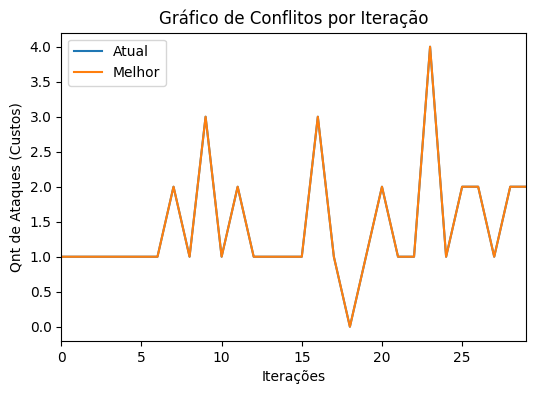

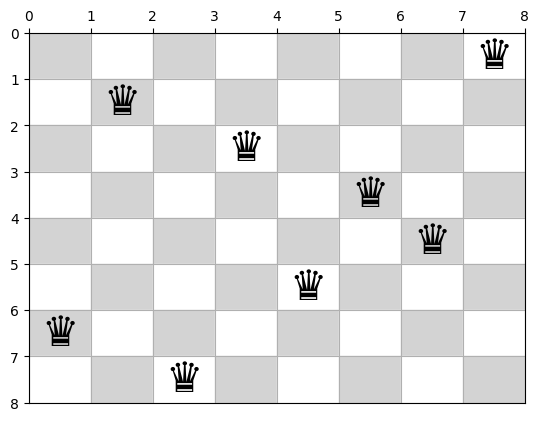

Melhor solução: [7, 2, 8, 3, 6, 4, 5, 1] com custo: 2


In [15]:

vetorInicial = solucao_aleatoria()

print("Tabuleiro recebido:", vetorInicial, "com custo:", conta_ataques(vetorInicial))
#plota_tabuleiro(vetorInicial)

custo, vetor_melhor = hill_climbing_restart(vetorInicial)

print("Melhor solução:", vetor_melhor, "com custo:", custo)
#plota_tabuleiro(vetor_melhor)

## Algoritmo 02: SA

In [16]:
def probabilidade_aceitacao(conflito_atual, novo_conflito, temperatura):
    if novo_conflito < conflito_atual: # melhor == menor (<)
        return 1.0
    else:
        return math.exp((conflito_atual - novo_conflito) / temperatura)

In [10]:
# Atualiza os gráficos

def plot_axes_figure_sa(lista_iteracoes, lista_aceitacao_prob, lista_temperatura, tabuleiro):

    x = lista_iteracoes
    y3 = lista_aceitacao_prob
    y4 = lista_temperatura

    clear_output(wait=True)

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,6))

    plot_acceptance_prob(x, y3, ax1)
    plot_temperature    (x, y4, ax2)
    plota_tabuleiro(tabuleiro)

    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()

    plt.pause(0.001)

In [17]:
# nrep: número de vizinhos gerados em cada iteração
def simulated_annealing(tabuleiro, nrep, iteracoes):
    #decaimento_min = 0.1
    #decaimento_max = 1
    cooling_rate = 0.995
    #iteracoes = 2000
    
    tabuleiro_atual = tabuleiro.copy()
    melhor_tabuleiro = tabuleiro_atual.copy()
    
    conflito_atual = conta_ataques(tabuleiro_atual)
    melhor_conflito = conflito_atual
    # Parâmetro: temperatura = 1000
    temperatura = 1000
    
    #-----------------------------------------------------
    lista_iteracoes = []
    lista_melhor_conflitos = []
    lista_conflitos = []
    lista_aceitacao_prob = []
    lista_temperatura = []
    #-----------------------------------------------------
    
    for iteracao in range(iteracoes):
        for _ in range(nrep):
            novo_tabuleiro, novo_conflito = obtem_melhor_vizinho(tabuleiro_atual, melhor_tabuleiro)
            
            aceitacao_prob = probabilidade_aceitacao(conflito_atual, novo_conflito, temperatura)

            if random.random() < aceitacao_prob:
                tabuleiro_atual = novo_tabuleiro
                conflito_atual = novo_conflito

        #decaimento = random.uniform(decaimento_min, decaimento_max)
        temperatura *= cooling_rate

        #-----------------------------------------------
        if novo_conflito < melhor_conflito:
            melhor_tabuleiro = novo_tabuleiro
            melhor_conflito = novo_conflito

        lista_iteracoes += [iteracao]
        lista_melhor_conflitos += [melhor_conflito]
        lista_conflitos  += [conflito_atual]
        lista_aceitacao_prob  += [aceitacao_prob]
        lista_temperatura  += [temperatura]

        if iteracao % 50 == 0:
            print(f"Iteração {iteracao}, melhor conflito: {melhor_conflito}")
            plot_axes_figure_sa(lista_iteracoes, lista_aceitacao_prob, lista_temperatura, melhor_tabuleiro)
        #-----------------------------------------------

    return melhor_conflito, melhor_tabuleiro

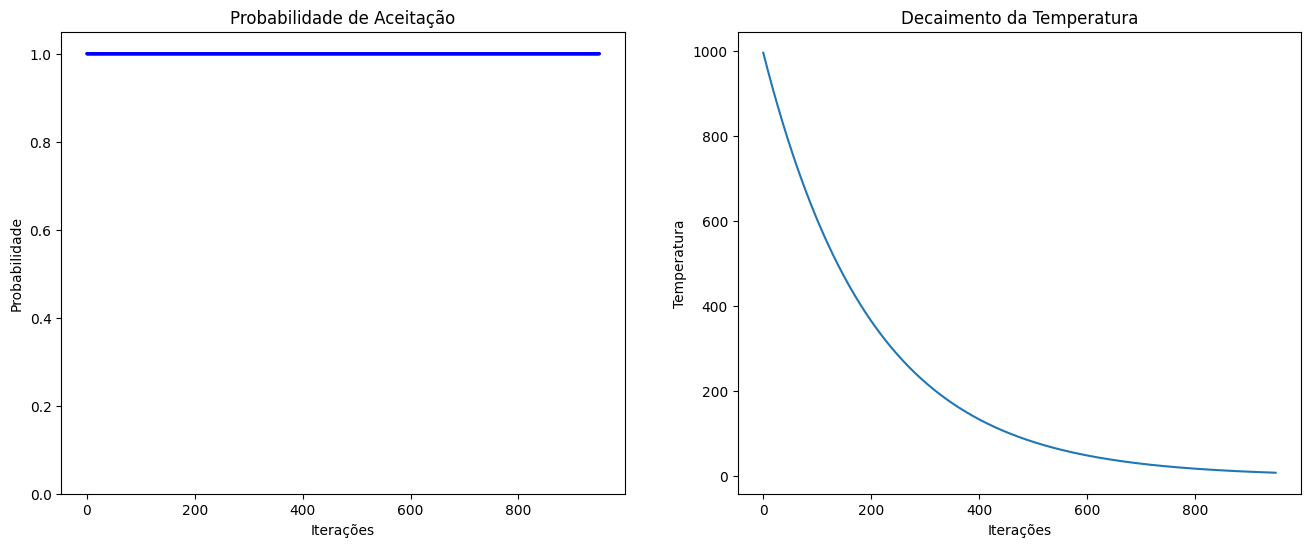

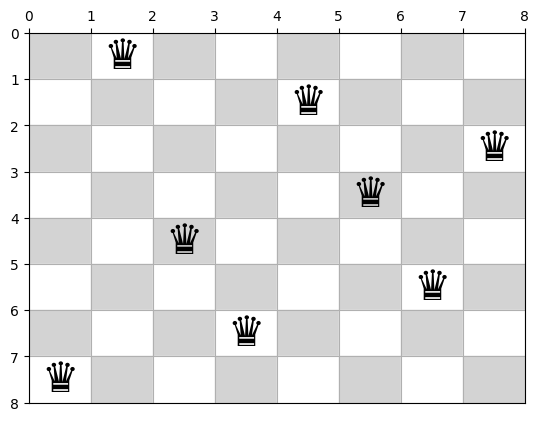

Melhor solução: [8, 1, 5, 7, 2, 4, 6, 3] com custo: 2


In [18]:
vetorInicial = solucao_aleatoria()

print("Tabuleiro recebido:", vetorInicial, "com custo:", conta_ataques(vetorInicial))
plota_tabuleiro(vetorInicial)

nrep = 50
iteracoes = 1000
custo, vetor_melhor = simulated_annealing(vetorInicial, nrep, iteracoes)

print("Melhor solução:", vetor_melhor, "com custo:", custo)
#plota_tabuleiro(vetor_melhor)